In [1]:
import datetime
import pandas as pd
import numpy as np
import re
from nltk.corpus import stopwords
import nltk
import networkx as nx
import scipy.sparse as sp
from math import log
import matplotlib
import matplotlib.pyplot as plt 
from matplotlib.patches import RegularPolygon, Ellipse
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib import cm, colorbar
from matplotlib.lines import Line2D
import gc
pd.options.display.max_colwidth = 5000
gc.collect()
from IPython.display import display, HTML
# import nltk
from nltk.corpus import wordnet as wn
from sklearn.feature_extraction.text import TfidfVectorizer
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\rajsa\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [2]:
cachedStopWords = stopwords.words("english")
def rem_stop_words(text):
    text = ' '.join([word for word in text.split() if word not in cachedStopWords])
    return text    
def decontracted(phrase):
    phrase = re.sub(r"won\'t", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase
def clean_str(string):
    string = string.strip().lower()
    string = rem_stop_words(string)
    string = decontracted(string)
    
    string = re.sub(r"<p>", " ", string)
    string = re.sub(r"</p>", " ", string)
    string = re.sub(r"\n", " ", string)
    string = re.sub(r"[^A-Za-z0-9(),!?\'\`]", " ", string)
#     string = re.sub(r"\'s", " \'s", string)
#     string = re.sub(r"\'ve", " \'ve", string)
#     string = re.sub(r"n\'t", " n\'t", string)
#     string = re.sub(r"\'re", " \'re", string)
#     string = re.sub(r"\'d", " \'d", string)
#     string = re.sub(r"\'ll", " \'ll", string)
    string = re.sub(r",", " , ", string)
    string = re.sub(r"!", " ! ", string)
    string = re.sub(r"\(", " \( ", string)
    string = re.sub(r"\)", " \) ", string)
    string = re.sub(r"\?", " \? ", string)
    string = re.sub(r"\s{2,}", " ", string)
    return string.strip().lower()
print(clean_str(' I am a boy my name is raj'))

boy name raj


In [3]:

tweets = pd.read_csv("multilabeledData.csv",sep=';') 
# tweets = pd.read_csv("labeleddata.csv",sep=';') 
# tweets = pd.read_csv("train.tsv",sep='\t') 
tweets["text"].fillna("Empty Tweet", inplace = True) 
tweets.head()
print(len(tweets.index))

1220


In [4]:
for row_number, tweet in tweets.iterrows():
    tweet['text'] = clean_str(tweet['text'])

In [5]:
def build_graph(tweets):
    id_tweet={}
    id_class={}
    labels={}
    num_docs = len(tweets.index)
#     We are getting ID numbers for rows and making different data structures
    for row_number, tweet in tweets.iterrows():
        id_tweet[row_number]=tweet['text']
        id_class[row_number]=tweet['class']
    # ------------------------------
#     We are determining the frequency of each word
#     And also determining which tweets contain a word
#     We are also creating a vocabulary set
    word_freq = {}
    word_doc_list = {}
    word_set = set()
    for key in id_tweet:
        appeared = set()
        tweet_words = id_tweet[key]
#         print(tweet_words)
        words = tweet_words.split()
        for word in words:
            word_set.add(word)
            if word in word_freq:
                word_freq[word] += 1
            else:
                word_freq[word] = 1
            if word in appeared:
                continue
            if word in word_doc_list:
                word_doc_list[word].append(key)
            else:
                word_doc_list[word] = [key]
            appeared.add(word)
#     print(word_freq['Tweet'])
    most_freq= [pair[0] for pair in sorted(word_freq.items(), key=lambda item: item[1], reverse = True)]
#     print(most_freq)
    most_freq=most_freq[0:10]
    print(most_freq)
    vocab = list(word_set)
#     print(vocab)
    vocab_size = len(vocab)     
    word_set.clear()
# ------------------------------  
#   Creating a map for word ,id
#   Creating a pair of word, number_of_documents_word_exists_in the data
    word_id_map = {}
    for i in range(vocab_size):
        word_id_map[vocab[i]] = i+num_docs
    word_doc_freq = {}
    for word, doc_list in word_doc_list.items():
        word_doc_freq[word] = len(doc_list)
    word_doc_list.clear()
    for i in vocab:
        labels[word_id_map[i]]=str(i)
# ------------------------------
    definitions = []
    word_embeddings_dim = 100
    word_vector_map = {}
    for word in vocab:
        word = word.strip()
        synsets = wn.synsets(clean_str(word))#clean_str
        word_defs = []
        for synset in synsets:
            syn_def = synset.definition()
            word_defs.append(syn_def)
        word_des = ' '.join(word_defs)
        if word_des == '':
            word_des = '<PAD>'
        definitions.append(word_des)
#     print(definitions)
    tfidf_vec = TfidfVectorizer(max_features=word_embeddings_dim)
    tfidf_matrix = tfidf_vec.fit_transform(definitions)
    tfidf_matrix_array = tfidf_matrix.toarray()
#     print(tfidf_matrix_array[0], len(tfidf_matrix_array[0]))

    word_vectors = []

    for i in range(len(vocab)):
        word = vocab[i]
        vector = tfidf_matrix_array[i]
        str_vector = []
        for j in range(len(vector)):
            str_vector.append(str(vector[j]))
        temp = ' '.join(str_vector)
        word_vector = word + ' ' + temp
        word_vectors.append(word_vector)
        word_vector_map[word] = vector
    print(len(word_vectors))
# ------------------------------
    row_x = []
    col_x = []
    data_x = []
    for i in range(num_docs):
        doc_vec = np.array([0.0 for k in range(word_embeddings_dim)])
        doc_words = id_tweet[i]
        words = doc_words.split()
        doc_len = len(words)
        for word in words:
            if word in word_vector_map:
                word_vector = word_vector_map[word]
                # print(doc_vec)
                # print(np.array(word_vector))
                doc_vec = doc_vec + np.array(word_vector)

        for j in range(word_embeddings_dim):
            row_x.append(i)
            col_x.append(j)
            # np.random.uniform(-0.25, 0.25)
            data_x.append(doc_vec[j] / doc_len)  # doc_vec[j]/ doc_len
    for i in range(len(vocab)):
        for j in range(word_embeddings_dim):
            row_x.append(i+num_docs)
            data_x.append(word_vector_map[vocab[i]][j])
            col_x.append(j)
# ------------------------------
#   each tweet is one window
    word_window_freq = {}
    num_window = 0
    for key in id_tweet:
        words = id_tweet[key]
        appeared = set()
        words = words.split()
        num_window+=1
        for word in words:
            if word in appeared:
                continue
            if word in word_window_freq:
                word_window_freq[word] += 1
            else:
                word_window_freq[word] = 1
        appeared.add(word)
            
# ------------------------------ 
    word_pair_count = {}  
    for key in id_tweet:
        words = id_tweet[key]
        words = words.split()
        for i in range(1, len(words)):
            for j in range(0, i):
                word_i = words[i]
                word_i_id = word_id_map[word_i]
                word_j = words [j]
                word_j_id = word_id_map[word_j]
                if word_i_id == word_j_id:
                    continue
                word_pair_str = str(word_i_id) + ',' + str(word_j_id)
                if word_pair_str in word_pair_count:
                    word_pair_count[word_pair_str] += 1
                else:
                    word_pair_count[word_pair_str] = 1
                # two orders
                word_pair_str = str(word_j_id) + ',' + str(word_i_id)
                if word_pair_str in word_pair_count:
                    word_pair_count[word_pair_str] += 1
                else:
                    word_pair_count[word_pair_str] = 1
# ------------------------------   
    row = []
    col = []
    weight = []
#     labels={}
# ------------------------------  
    for key in word_pair_count:
        temp = key.split(',')
        #my, name 2
        i = int(temp[0])
        j = int(temp[1])
        count = word_pair_count[key]#2
        word_freq_i = word_window_freq[vocab[i-num_docs]]# number of windows  my occurs
        word_freq_j = word_window_freq[vocab[j-num_docs]]
        pmi = log((1.0 * count / num_window) /
                  (1.0 * word_freq_i * word_freq_j/(num_window * num_window)))
        if pmi <= 0:
            continue
        row.append(i)
        col.append(j)
        weight.append(pmi)
    word_window_freq.clear()
    word_pair_count.clear()
# ------------------------------
    doc_word_freq = {}
    #{(document_id,word_id), frequency}
    for key in id_tweet:
        words = id_tweet[key]
        words = words.split()
        for word in words:
            word_id = word_id_map[word]
            doc_word_str = str(key) + ',' + str(word_id)
            if doc_word_str in doc_word_freq:
                doc_word_freq[doc_word_str] += 1
            else:
                doc_word_freq[doc_word_str] = 1
# ------------------------------
    for key in id_tweet:
        words = id_tweet[key]
        doc_word_set = set()
        words = words.split()
        for word in words:
            if word in doc_word_set:
                continue
            j = word_id_map[word]
            key1 = str(key) + ',' + str(j)# document_id, word_id
            freq = doc_word_freq[key1]
            row.append(key)
            col.append(j)
            idf = log(1.0 * num_docs /
                      word_doc_freq[vocab[j-num_docs]])
            weight.append(freq * idf)
            doc_word_set.add(word)
    for i in id_tweet:
        labels[ i] = str(i)
    word_freq.clear()
    doc_word_freq.clear()
# ------------------------------
    node_size = vocab_size + num_docs
    
    
    adj = sp.csr_matrix(
        (weight, (row, col)), shape=(node_size, node_size))
#     G = nx.Graph()
#     features = sp.identity(node_size) 
    features = sp.csr_matrix(
        (data_x, (row_x, col_x)), shape=(node_size, word_embeddings_dim))
    G = nx.from_scipy_sparse_matrix(adj)
    temp = np.identity(node_size, dtype = float) 
    
    return G,vocab_size, num_docs, adj, features, node_size, labels, id_tweet, id_class

In [6]:
G,vocab_size, num_docs, adj, features, node_size, label, id_tweet, id_class = build_graph(tweets)

['malware', 'ransomware', 'cve', 'attack', 'new', '2020', 'security', 'cyber', 'vulnerability', 'coronavirus']
3835


C:\Users\rajsa\Anaconda3\envs\tf\lib\site-packages\ipykernel_launcher.py:110: RuntimeWarning: invalid value encountered in double_scalars


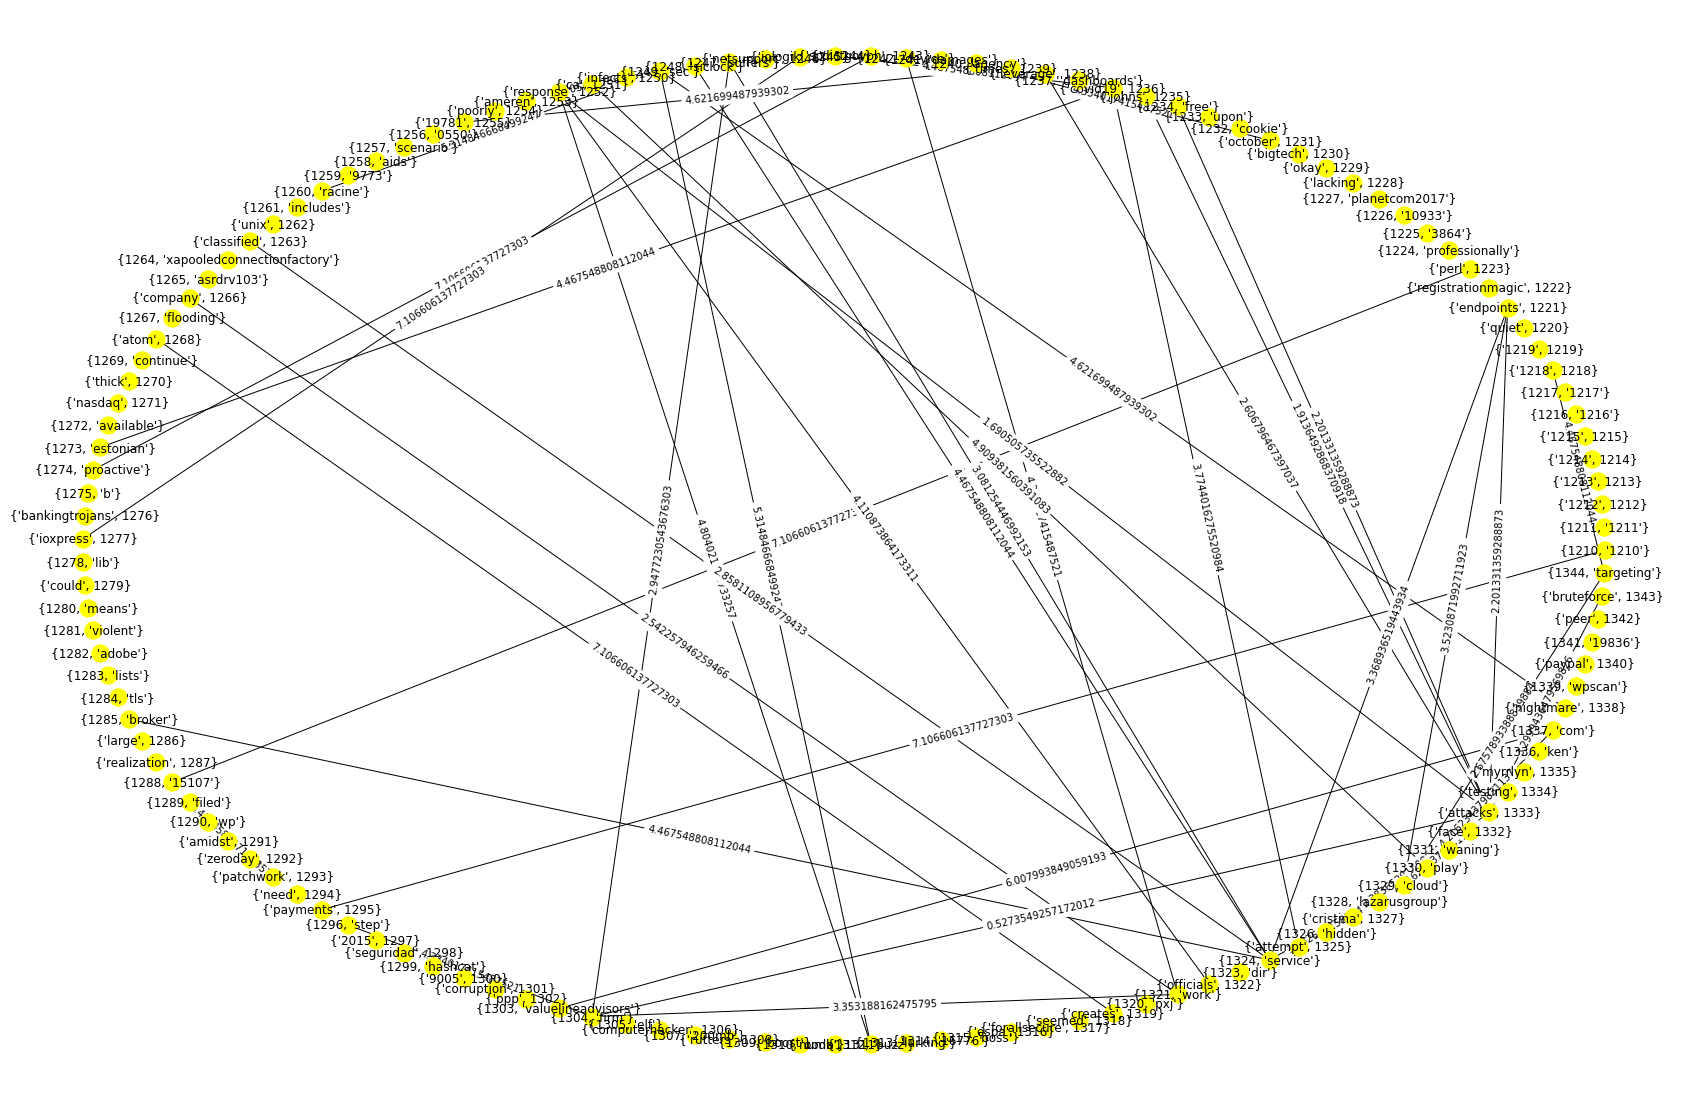

12928

In [7]:
plt.figure(figsize=(30,20))
# l = [*range(vocab_size1+max_doc_id1,vocab_size1+max_doc_id1+35)]
l = [*range(num_docs - 10, num_docs + 125)]
label_1 = {}
for i in l:
    label_1[i] = {label[i], i}
b = G.subgraph(l)
pos = nx.circular_layout(b)

# pos = nx.spring_layout(b)
l1 = nx.get_edge_attributes(b,'weight')
nx.draw_networkx_edge_labels(b,pos,edge_labels=l1)
nx.draw_circular(b, with_labels= True, labels= label_1, node_color= 'yellow')
# plt.savefig("Graph.eps", format="eps")
plt.show()
gc.collect()

In [8]:
features

<5055x100 sparse matrix of type '<class 'numpy.float64'>'
	with 505500 stored elements in Compressed Sparse Row format>

In [9]:
def sample_mask(idx, l):
    """Create mask."""
    mask = np.zeros(l)
    mask[idx] = 1
    return np.array(mask, dtype=np.bool)

In [10]:
real_train_size = int(num_docs * 0.9)
real_test_size = int(num_docs*0.05)
real_val_size = int(num_docs*0.05)

In [11]:
idx_train = range(real_train_size)
idx_test = range(real_train_size, real_train_size + real_test_size)
idx_val = range(real_train_size + real_test_size, real_train_size + real_test_size + real_val_size)

In [12]:
output = []
for x in id_class.items():
    if x[1] not in output:
        output.append(x[1])
label_list = list(output)


In [13]:
y = []
for i in range(num_docs):
    label = id_class[i]
#     temp = classes.split('\t')
#     label = temp[2]
    one_hot = [0 for l in range(len(label_list))]
    label_index = label_list.index(label)
    one_hot[label_index] = 1
    y.append(one_hot)
for i in range(num_docs, node_size):
    one_hot = [0 for l in range(len(label_list))]
    y.append(one_hot)
y = np.array(y)
# print(y[0:10])

In [14]:
train_mask = sample_mask(idx_train, node_size)
val_mask = sample_mask(idx_val, node_size)
test_mask = sample_mask(idx_test,node_size)

In [15]:
y

array([[1, 0, 0, 0, 0],
       [1, 0, 0, 0, 0],
       [0, 1, 0, 0, 0],
       ...,
       [0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0]])

In [16]:
y_train = np.zeros(y.shape)
y_val = np.zeros(y.shape)
y_test = np.zeros(y.shape)
y_train[train_mask, :] = y[train_mask, :]
y_val[val_mask, :] = y[val_mask, :]
y_test[test_mask, :] = y[test_mask, :]
adj = adj + adj.T.multiply(adj.T > adj) - adj.multiply(adj.T > adj)

In [17]:
import time
import tensorflow as tf

from sklearn import metrics
from utils import *
from models import GCN, MLP
import random
import os
import sys

In [18]:
seed = random.randint(1, 200)
np.random.seed(seed)
tf.set_random_seed(seed)

# Settings
os.environ["CUDA_VISIBLE_DEVICES"] = ""

flags = tf.app.flags 
FLAGS = tf.app.flags.FLAGS
# 'cora', 'citeseer', 'pubmed']
tf.app.flags.DEFINE_string('f', '', 'kernel')
flags.DEFINE_string('dataset', 'dataset', 'Dataset string.')
# 'gcn', 'gcn_cheby', 'dense'
flags.DEFINE_string('model', 'gcn', 'Model string.')
flags.DEFINE_float('learning_rate', 0.001, 'Initial learning rate.')
flags.DEFINE_integer('epochs', 200, 'Number of epochs to train.')
flags.DEFINE_integer('hidden1', 200, 'Number of units in hidden layer 1.')
flags.DEFINE_float('dropout', 0.2, 'Dropout rate (1 - keep probability).')
flags.DEFINE_float('weight_decay', 0,
                   'Weight for L2 loss on embedding matrix.')  # 5e-4
flags.DEFINE_integer('early_stopping', 30,
                     'Tolerance for early stopping (# of epochs).')
flags.DEFINE_integer('max_degree', 3, 'Maximum Chebyshev polynomial degree.')

In [19]:
print(adj.shape)
print(features.shape)
features = preprocess_features(features)

(5055, 5055)
(5055, 100)


C:\Users\rajsa\Desktop\mining_twitter\gcn_text\utils.py:239: RuntimeWarning: divide by zero encountered in power
  r_inv = np.power(rowsum, -1).flatten()


In [20]:

# if FLAGS.model == 'gcn':
support = [preprocess_adj(adj)]
num_supports = 1
model_func = GCN
# elif FLAGS.model == 'gcn_cheby':
#     support = chebyshev_polynomials(adj, FLAGS.max_degree)
#     num_supports = 1 + FLAGS.max_degree
#     model_func = GCN
# elif FLAGS.model == 'dense':
#     support = [preprocess_adj(adj)]  # Not used
#     num_supports = 1
#     model_func = MLP
# else:
#     raise ValueError('Invalid argument for model: ' + str(FLAGS.model))

In [21]:
placeholders = {
    'support': [tf.sparse_placeholder(tf.float32) for _ in range(num_supports)], # The Supporting matrix (Adjacency)
    'features': tf.sparse_placeholder(tf.float32, shape=tf.constant(features[2], dtype=tf.int64)),
    'labels': tf.placeholder(tf.float32, shape=(None, y_train.shape[1])),
    'labels_mask': tf.placeholder(tf.int32),
    'dropout': tf.placeholder_with_default(0., shape=()),
    # helper variable for sparse dropout
    'num_features_nonzero': tf.placeholder(tf.int32)
}

In [22]:
print(features[2])

# Go to GCN class's constructor in models.py
model = model_func(placeholders, input_dim=features[2][0], logging=True)

# Initialize session
session_conf = tf.ConfigProto(gpu_options=tf.GPUOptions(allow_growth=True))
sess = tf.Session(config=session_conf)


# Define model evaluation function
def evaluate(features, support, labels, mask, placeholders):
    t_test = time.time()
    feed_dict_val = construct_feed_dict(
        features, support, labels, mask, placeholders)
    outs_val = sess.run([model.loss, model.accuracy, model.pred, model.labels], feed_dict=feed_dict_val)
    return outs_val[0], outs_val[1], outs_val[2], outs_val[3], (time.time() - t_test)


# Init variables
# Session has started running
sess.run(tf.global_variables_initializer())

cost_val = []

# Train model
for epoch in range(FLAGS.epochs):

    t = time.time()
    # Construct feed dictionary
    feed_dict = construct_feed_dict(
        features, support, y_train, train_mask, placeholders)
    feed_dict.update({placeholders['dropout']: FLAGS.dropout})

    # Training step
    outs = sess.run([model.opt_op, model.loss, model.accuracy,
                     model.layers[0].embedding], feed_dict=feed_dict)

    # Validation
    cost, acc, pred, labels, duration = evaluate(
        features, support, y_val, val_mask, placeholders)
    cost_val.append(cost)

    print("Epoch:", '%04d' % (epoch + 1), "train_loss=", "{:.5f}".format(outs[1]),
          "train_acc=", "{:.5f}".format(
              outs[2]), "val_loss=", "{:.5f}".format(cost),
          "val_acc=", "{:.5f}".format(acc), "time=", "{:.5f}".format(time.time() - t))

    if epoch > FLAGS.early_stopping and cost_val[-1] > np.mean(cost_val[-(FLAGS.early_stopping+1):-1]):
        print("Early stopping...")
        break

print("Optimization Finished!")

# Testing
test_cost, test_acc, pred, labels, test_duration = evaluate(
    features, support, y_test, test_mask, placeholders)
print("Test set results:", "cost=", "{:.5f}".format(test_cost),
      "accuracy=", "{:.5f}".format(test_acc), "time=", "{:.5f}".format(test_duration))

test_pred = []
test_labels = []
print(len(test_mask))
for i in range(len(test_mask)):
    if test_mask[i]:
        test_pred.append(pred[i])
        test_labels.append(labels[i])

print("Test Precision, Recall and F1-Score...")
print(metrics.classification_report(test_labels, test_pred, digits=4))
print("Macro average Test Precision, Recall and F1-Score...")
print(metrics.precision_recall_fscore_support(test_labels, test_pred, average='macro'))
print("Micro average Test Precision, Recall and F1-Score...")
print(metrics.precision_recall_fscore_support(test_labels, test_pred, average='micro'))

(5055, 100)


First in Layer Class



First in Layer Class



Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


Tensor("graphconvolution_2/SparseTensorDenseMatMul/SparseTensorDenseMatMul:0", shape=(?, 5), dtype=float32)
Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See `tf.nn.softmax_cross_entropy_with_logits_v2`.

Epoch: 0001 train_loss= 1.61000 train_acc= 0.16576 val_loss= 1.60806 val_acc= 0.44262 time= 0.43285
Epoch: 0002 train_loss= 1.60715 train_acc= 0.52277 val_loss= 1.60623 val_acc= 0.57377 time= 0.21745
Epoch: 0003 train_loss= 1.60427 train_acc= 0.80237 val_loss= 1.60440 val_acc= 0.59016 time= 0.23043
Epoch: 0004 train_loss= 1.60140 train_acc= 0.90802 val_loss= 1.60250 val_acc= 0.62295 time= 0.21633
Epoch: 0005 train_loss= 1.59854 train_acc= 0.93169 val_loss= 1.60055 val_acc= 0.60656 time= 0.22916
Epoch: 0006 train_loss

Epoch: 0060 train_loss= 1.25339 train_acc= 0.94991 val_loss= 1.37136 val_acc= 0.65574 time= 0.25220
Epoch: 0061 train_loss= 1.24391 train_acc= 0.95355 val_loss= 1.36521 val_acc= 0.65574 time= 0.24212
Epoch: 0062 train_loss= 1.23404 train_acc= 0.95446 val_loss= 1.35902 val_acc= 0.65574 time= 0.24003
Epoch: 0063 train_loss= 1.22469 train_acc= 0.95629 val_loss= 1.35278 val_acc= 0.65574 time= 0.23334
Epoch: 0064 train_loss= 1.21373 train_acc= 0.95355 val_loss= 1.34652 val_acc= 0.65574 time= 0.24393
Epoch: 0065 train_loss= 1.20470 train_acc= 0.95446 val_loss= 1.34021 val_acc= 0.65574 time= 0.24632
Epoch: 0066 train_loss= 1.19396 train_acc= 0.95629 val_loss= 1.33387 val_acc= 0.65574 time= 0.25977
Epoch: 0067 train_loss= 1.18384 train_acc= 0.95537 val_loss= 1.32751 val_acc= 0.65574 time= 0.24193
Epoch: 0068 train_loss= 1.17390 train_acc= 0.95537 val_loss= 1.32111 val_acc= 0.65574 time= 0.26339
Epoch: 0069 train_loss= 1.16154 train_acc= 0.95629 val_loss= 1.31469 val_acc= 0.65574 time= 0.26206


Epoch: 0142 train_loss= 0.48097 train_acc= 0.96630 val_loss= 0.95590 val_acc= 0.62295 time= 0.24600
Epoch: 0143 train_loss= 0.47444 train_acc= 0.96721 val_loss= 0.95395 val_acc= 0.62295 time= 0.25117
Epoch: 0144 train_loss= 0.46782 train_acc= 0.96630 val_loss= 0.95209 val_acc= 0.62295 time= 0.24438
Epoch: 0145 train_loss= 0.46349 train_acc= 0.96539 val_loss= 0.95031 val_acc= 0.62295 time= 0.22304
Epoch: 0146 train_loss= 0.45697 train_acc= 0.96630 val_loss= 0.94861 val_acc= 0.62295 time= 0.24353
Epoch: 0147 train_loss= 0.45114 train_acc= 0.96721 val_loss= 0.94698 val_acc= 0.62295 time= 0.24977
Epoch: 0148 train_loss= 0.44397 train_acc= 0.96721 val_loss= 0.94543 val_acc= 0.62295 time= 0.23988
Epoch: 0149 train_loss= 0.44050 train_acc= 0.96813 val_loss= 0.94398 val_acc= 0.62295 time= 0.24792
Epoch: 0150 train_loss= 0.43387 train_acc= 0.97086 val_loss= 0.94261 val_acc= 0.62295 time= 0.21833
Epoch: 0151 train_loss= 0.42909 train_acc= 0.97177 val_loss= 0.94131 val_acc= 0.62295 time= 0.23401
